# Compare different scenarios 

In [1]:
import matplotlib.pyplot as plt
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
import model.model as mod_code
import model.base_inputs as inp
import plot.scenario_comparison as plt_sc
import imp
import numpy as np
import pickle
import os
import copy
imp.reload(mod_code)

<module 'model.model' from '/home/twilliams/adaptation_abm/code/model/model.py'>

## Define scenarios 

In [17]:
# load default params
inp_base = inp.compile()
#### OR ####
# load from POM experiment
# f = '../../outputs/2019_11_12_2/POM/100000_10reps/input_params_0.pkl'
# f = '../../outputs/es_r1_fertilizer/POM/100000_10reps/input_params_0.pkl'
# f = '../../outputs/es_r1_sims/POM/100000_10reps/input_params_0.pkl'
f = '../../outputs/es_r2/POM/100000_10reps/input_params_0.pkl'
inp_base = pickle.load(open(f, 'rb'))

# manually specify some variables (common to all scenarios)
inp_base['model']['T'] = 50
inp_base['model']['n_agents'] = 60
inp_base['model']['exp_name'] = 'scenario_compare'
inp_base['agents']['adap_type'] = 'always'
inp_base['model']['seed'] = 0
inp_base['climate']['rain_mu'] = 0.5 # changing from 0.6 2021/4/29
# things not in the POM
inp_base['agents']['land_area_multiplier'] = 1

# define some scenarios
## adaptation scenarios
scenarios = {
    'baseline' : {'model' : {'adaptation_option' : 'none'}},
    'insurance' : {'model' : {'adaptation_option' : 'insurance'}},
    'cover_crop' : {'model' : {'adaptation_option' : 'cover_crop'}},
}

# ## shock scenarios
# scenarios = {
#     'baseline' : {'model' : {'adaptation_option' : 'none', 'shock' : False}},
#     'shock' : {'model' : {'adaptation_option' : 'none', 'shock' : True}, 'climate' : {'shock_years' : [15], 'shock_rain' : 0.1}},
# }

# scenarios = {
#     'shock_cc' : {'model' : {'adaptation_option' : 'cover_crop', 'shock' : True}, 'climate' : {'shock_years' : [25], 'shock_rain' : 0.1}},
#     'shock_ins' : {'model' : {'adaptation_option' : 'insurance', 'shock' : True}, 'climate' : {'shock_years' : [25], 'shock_rain' : 0.1}},
# }

In [18]:
# inp_base['adaptation']['burnin_period'] = 10
# inp_base['adaptation']['cover_crop']['cost_factor'] = 1
# inp_base['agents']['wealth_init_mean'] = 40000
# inp_base['agents']['n_plots_init'] = [8,11,100]
# inp_base['adaptation']['cover_crop']['N_fixation_min'] = 40
# inp_base['adaptation']['cover_crop']['N_fixation_max'] = 200
# inp_base['model']['shock'] = False
# inp_base['land']['crop_CN_conversion'] = 15
# inp_base['land']['residue_CN_conversion'] = 60

In [19]:
# inp_base['adaptation']['cover_crop']['cost_factor'] = 1
# inp_base['adaptation']['insurance']['climate_percentile'] = 0.01
# inp_base['land']['rain_cropfail_low_SOM'] = 0.25
# inp_base['climate']['rain_mu'] = 0.5

## Run the model

In [20]:
mods = {}
for name, vals in scenarios.items():
    # change the params
    params = copy.copy(inp_base)
    for k, v in vals.items():
        for k2, v2 in v.items():
            params[k][k2] = v2
    
    # initialize and run model
    m = mod_code.Model(params)
    for t in range(m.T):
        m.step()
    mods[name] = m

In [21]:
# # print(mods['baseline'].agents.income[20])
# print(mods['insurance'].agents.income[20])
# print(mods['insurance'].agents.coping_rqd[20])
# # print(mods['baseline'].agents.wealth[20])
# print(mods['insurance'].agents.wealth[20])
# print(mods['insurance'].agents.wealth[21])


In [22]:
# plt.plot(m.climate.rain, m.land.yields,'o')

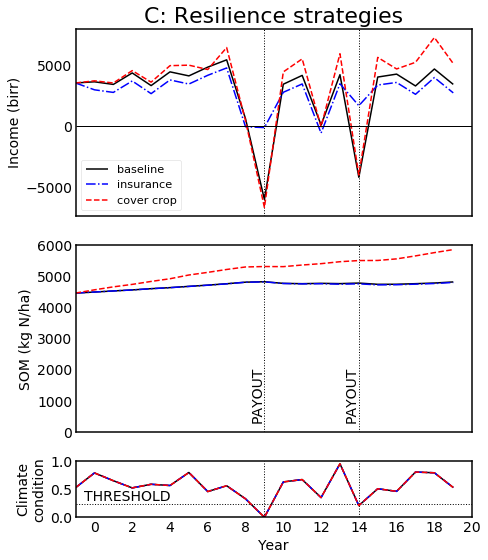

In [23]:
savedir = '../../outputs/es_r2/representative_sim/'
if not os.path.exists(savedir):
    os.mkdir(savedir)
imp.reload(plt_sc)
plt_sc.combined_plots(mods, savedir)

In [ ]:
imp.reload(plt_sc)
plt_sc.main(mods, save=False)

In [ ]:
has_shock = True if 'shock' in mods.keys() else False
# plot wealth for an agent of type 2 only
fig, ax = plt.subplots(figsize=(7,4))
for m, mod in mods.items():
    lands = mod.agents.land_area
    uniq_land = np.unique(lands)
    if has_shock:
        ax.plot(mod.agents.wealth[:,lands==uniq_land[1]][:,0], label=m)
    else:
        ax.plot(mod.agents.income[:,lands==uniq_land[1]][:,1], label=m)
    burnin = mod.adap_properties['burnin_period']
    if mod.shock:
        for yr in mod.climate.shock_years:
            ax.axvline(x=yr, color='k', ls=':')
            ax.text(yr, ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.1, 'SHOCK', ha='center', va='bottom', rotation=90)
            
    if m == 'insurance':
        shock_yrs = np.where(mod.climate.rain <= mod.adap_properties['magnitude'])[0]
        for yr in shock_yrs:
            ax.axvline(x=yr, color='r', lw=1, ls=':')
        
if has_shock:
    T = 8
    ax.set_xlim([yr-3, yr+T])
    ax.set_xticks(np.arange(yr-2,yr+T+1,2))
    ax.set_xticklabels(np.arange(yr-2,yr+T+1,2))
else:
    T = 21
    ax.set_xlim([burnin, burnin+T])
    ax.set_xticks(np.arange(burnin+1, burnin+T+1,2))
    ax.set_xticklabels(np.arange(0,T,2))
ax.axhline(y=0, color='k', ls=':')
        
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Wealth' if has_shock else 'Income')
ax.grid(False)
text = 'B: Effect of shock' if has_shock else 'C: Resilience strategies'
# ax.text(-0.2,1.1, text, transform=ax.transAxes, fontsize=22)
ax.set_title(text, fontsize=22)
